# 🎬 Cinematch: A Content-Based Movie Recommender System

## 1. Introduction

This notebook details the end-to-end process of building **Cinematch**, a content-based movie recommendation engine. The goal is to recommend movies to users based on the thematic and metadata similarity to a movie they have already enjoyed.

The project follows these key steps:
1.  **Data Loading & Exploration:** We begin by loading three distinct datasets containing movie metadata, cast/crew information, and keywords. We will perform initial exploratory data analysis (EDA) to understand the data's structure and distributions.
2.  **Preprocessing & Feature Engineering:** The raw data is cleaned, merged, and transformed. A key step is creating a "soup" of textual features for each movie, combining its overview, genres, keywords, director, and top cast members.
3.  **Model Building:** Using the engineered text features, we apply a TF-IDF (Term Frequency-Inverse Document Frequency) vectorizer to convert the text into a numerical matrix. A K-Nearest Neighbors model is then trained on this matrix to find the most similar movies based on cosine similarity.
4.  **Evaluation & Interpretation:** Since traditional accuracy metrics don't apply, we evaluate the model both qualitatively (through "sanity checks") and quantitatively (by measuring recommendation diversity). We also implement a method to interpret *why* a specific recommendation was made by identifying shared keywords.
5.  **Exporting Artifacts:** The final, processed data and trained model are saved into a single `.pkl` file for easy loading into the deployed Streamlit application.

---
**Download Dataset:** [The Movies Dataset](https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset)

**Project by:** Muhammad Tahir
- [LinkedIn](https://www.linkedin.com/in/muhammad-tahir-data/)

In [134]:
import pandas as pd
import numpy as np
import ast # For safely evaluating string representations of lists/dicts
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
import pickle
import sys
# Set plotting style
sns.set_style('whitegrid')

In [135]:
df_meta = pd.read_csv(r'C:\Users\Dell\Desktop\Movie Recommender System\Final files\movies_metadata.csv', low_memory=False)
df_credits = pd.read_csv(r'C:\Users\Dell\Desktop\Movie Recommender System\Final files\credits.csv')
df_keywords = pd.read_csv(r'C:\Users\Dell\Desktop\Movie Recommender System\Final files\keywords.csv')

## 2. Exploratory Data Analysis (EDA) & Preprocessing

Before building the model, it's crucial to understand the data we're working with. We'll start by inspecting the datasets and then perform some basic visualizations.

In [136]:
# quick look at the data
print("Movies Metadata:")
display(df_meta.head(2))
print("\nCredits:")
display(df_credits.head(2))
print("\nKeywords:")
display(df_keywords.head(2))

print("\nMetadata Info:")
df_meta.info()

Movies Metadata:


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0



Credits:


,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844



Keywords:


,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."



Metadata Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null 

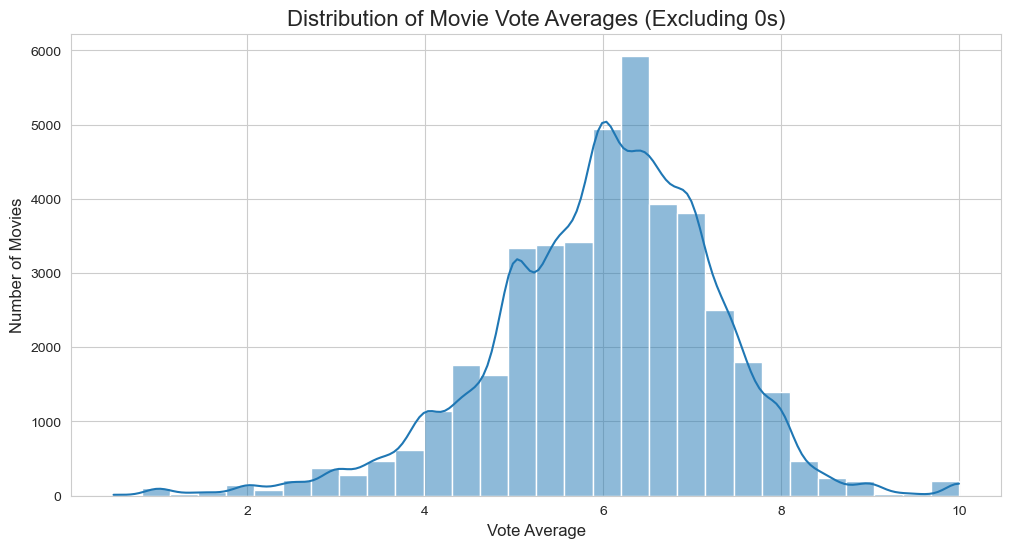

In [137]:
# Visualize the distribution of movie ratings
# First, convert 'vote_average' to numeric, coercing errors
df_meta['vote_average'] = pd.to_numeric(df_meta['vote_average'], errors='coerce').fillna(0)

plt.figure(figsize=(12, 6))
sns.histplot(df_meta[df_meta['vote_average'] > 0]['vote_average'], bins=30, kde=True)
plt.title('Distribution of Movie Vote Averages (Excluding 0s)', fontsize=16)
plt.xlabel('Vote Average', fontsize=12)
plt.ylabel('Number of Movies', fontsize=12)
plt.show()

### --- Preprocessing ---

In [138]:
# clean the 'id' column in the metadata to ensure it can be merged
# some IDs are not numeric, so we filter them out
df_meta = df_meta[df_meta['id'].str.isnumeric()]
df_meta['id'] = df_meta['id'].astype(int)

In [139]:
# merge the three dataframes into a single master dataframe
df = df_meta.merge(df_credits, on='id')
df = df.merge(df_keywords, on='id')

In [140]:
# for this content-based recommender, we only need a few columns
# we'll also keep 'poster_path', 'overview', 'release_date', 'vote_average' for the app display
df = df[['id', 'title', 'overview', 'genres', 'keywords', 'cast', 'crew', 'poster_path', 'release_date', 'vote_average']].copy()

In [141]:
df.head(3)

,id,title,overview,genres,keywords,cast,crew,poster_path,release_date,vote_average
0,862,Toy Story,"Led by Woody, Andy's toys live happily in his ...","[{'id': 16, 'name': 'Animation'}, {'id': 35, '...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...","[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,1995-10-30,7.7
1,8844,Jumanji,When siblings Judy and Peter discover an encha...,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...","[{'id': 10090, 'name': 'board game'}, {'id': 1...","[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,1995-12-15,6.9
2,15602,Grumpier Old Men,A family wedding reignites the ancient feud be...,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392...","[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,1995-12-22,6.5


In [142]:
# drop rows where the title is missing, as these are unusable.
df.dropna(subset=['title'], inplace=True)

In [143]:
# fill any remaining NaNs in our feature columns with empty representations.
for col in ['overview', 'genres', 'keywords', 'cast', 'crew']:
    if ']' in str(df[col].iloc[0]):
        df[col] = df[col].fillna('[]') # For list-like columns
    else:
        df[col] = df[col].fillna('') # For text columns

### --- Feature Engineering ---

In [144]:
# helper functions to parse the stringified JSON-like columns

# safely parse a stringified list of dictionaries and extract names
def get_list(text):
    try:
        return [i['name'] for i in ast.literal_eval(text)]
    except (ValueError, SyntaxError, TypeError):
        return []

# find the director from the 'crew' column
def get_director(text):
    try:
        for i in ast.literal_eval(text):
            if i.get('job') == 'Director':
                return i['name']
        return ''
    except (ValueError, SyntaxError, TypeError):
        return ''

# apply the parsing functions to the respective columns.
df['genres'] = df['genres'].apply(get_list)
df['keywords'] = df['keywords'].apply(get_list)
df['cast'] = df['cast'].apply(lambda x: get_list(x)[:3]) # We only take the top 3 actors
df['director'] = df['crew'].apply(get_director)

In [145]:
# to make keywords more distinct (e.g., 'jamescameron' instead of 'james cameron'),
# we remove spaces from all list items and the director's name.
def clean_text_list(lst):
    return [str(i).replace(" ", "").lower() for i in lst]

for col in ['genres', 'keywords', 'cast']:
    df[col] = df[col].apply(clean_text_list)
df['director'] = df['director'].apply(lambda x: str(x).replace(" ", "").lower())

In [146]:
df.head(3)

,id,title,overview,genres,keywords,cast,crew,poster_path,release_date,vote_average,director
0,862,Toy Story,"Led by Woody, Andy's toys live happily in his ...","[animation, comedy, family]","[jealousy, toy, boy, friendship, friends, riva...","[tomhanks, timallen, donrickles]","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,1995-10-30,7.7,johnlasseter
1,8844,Jumanji,When siblings Judy and Peter discover an encha...,"[adventure, fantasy, family]","[boardgame, disappearance, basedonchildren'sbo...","[robinwilliams, jonathanhyde, kirstendunst]","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,1995-12-15,6.9,joejohnston
2,15602,Grumpier Old Men,A family wedding reignites the ancient feud be...,"[romance, comedy]","[fishing, bestfriend, duringcreditsstinger, ol...","[waltermatthau, jacklemmon, ann-margret]","[{'credit_id': '52fe466a9251416c75077a89', 'de...",/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,1995-12-22,6.5,howarddeutch


### Feature Engineering Analysis

After parsing and cleaning, the dataframe is now perfectly structured for feature engineering. The `genres`, `keywords`, and `cast` columns have been successfully transformed into clean lists of lowercase, space-free strings (e.g., `tomhanks`). This ensures the TF-IDF vectorizer will treat each as a unique and consistent token. The `director` column has also been correctly extracted.

### Creating the "Feature Soup"

The core of our content-based recommender lies in creating a single, combined text field for each movie that represents its key features. We call this the "soup". This soup will be fed into our TF-IDF vectorizer. We will give more weight to the director and cast by repeating them in the soup.

In [147]:
# combine all our text features into a single string or "soup"
# we give higher weight to the director by repeating the name 3 times
def create_soup(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres']) + ' ' + x['overview']

df['soup'] = df.apply(create_soup, axis=1)

In [148]:
# let's look at an example soup for a well-known movie
print("--- Feature Soup for 'The Dark Knight' ---")
print(df[df['title'] == 'The Dark Knight']['soup'].values[0])

--- Feature Soup for 'The Dark Knight' ---
dccomics crimefighter secretidentity scarecrow sadism chaos gothamcity vigilante joker superhero basedoncomic tragichero organizedcrime criminalmastermind districtattorney imax supervillain superpowers batman christianbale michaelcaine heathledger christophernolan drama action crime thriller Batman raises the stakes in his war on crime. With the help of Lt. Jim Gordon and District Attorney Harvey Dent, Batman sets out to dismantle the remaining criminal organizations that plague the streets. The partnership proves to be effective, but they soon find themselves prey to a reign of chaos unleashed by a rising criminal mastermind known to the terrified citizens of Gotham as the Joker.


C:\Users\Dell\AppData\Local\Temp\ipykernel_3148\1200743336.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_genres.values, y=top_genres.index, palette='viridis')


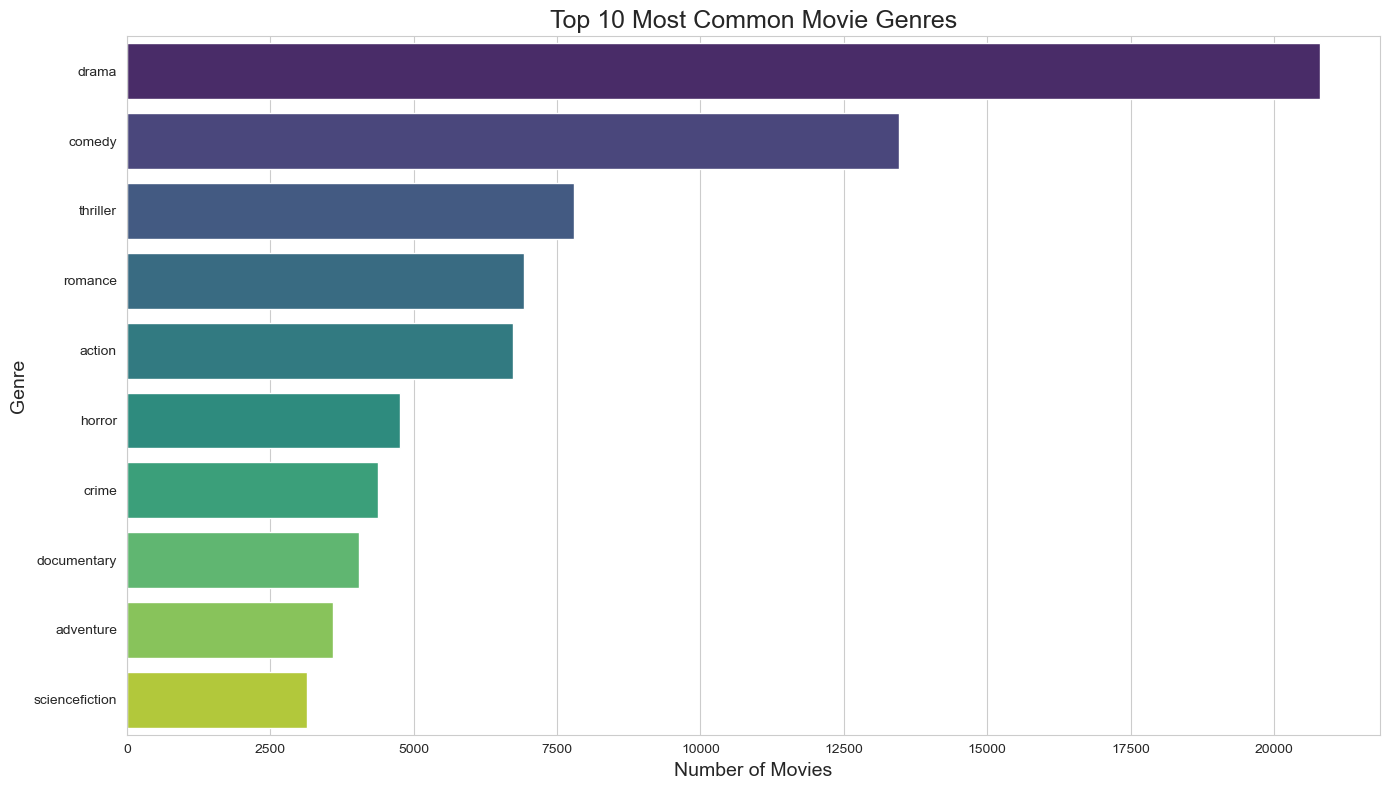

In [149]:
# to analyze genres, we first need to count the occurrences of each one
# since each movie can have multiple genres, we flatten the list of lists into a single series
all_genres = pd.Series([genre for sublist in df['genres'] for genre in sublist])

# Now we can get the counts of the top 20 most common genres
top_genres = all_genres.value_counts().head(10)

# create the bar plot
plt.figure(figsize=(14, 8))
sns.barplot(x=top_genres.values, y=top_genres.index, palette='viridis')
plt.title('Top 10 Most Common Movie Genres', fontsize=18)
plt.xlabel('Number of Movies', fontsize=14)
plt.ylabel('Genre', fontsize=14)
plt.tight_layout()
plt.show()

### Genre Distribution Analysis

The bar chart above reveals the distribution of genres across our dataset. **Drama** is by far the most prevalent genre, followed closely by **Comedy**, **Thriller**, and **Romance**. This is a typical distribution for large movie datasets, as many films contain dramatic or comedic elements. The presence of a wide variety of genres, from Action to Science Fiction, indicates that our dataset is rich enough to make diverse recommendations. This also suggests that genre will be a very strong feature in our "soup" for differentiating movies.

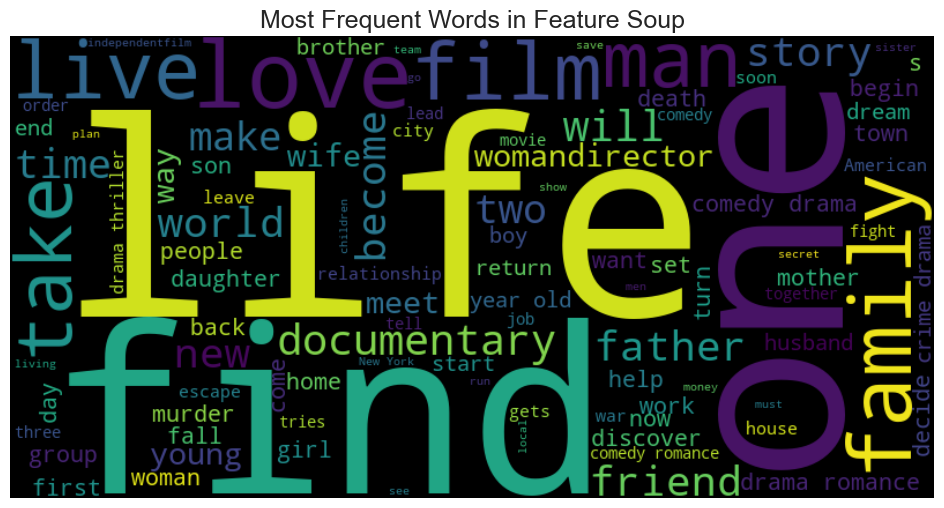

In [150]:
# to get a feel for the most common terms that will drive our recommendations
# let's create a word cloud from the 'soup' of a subset of our data
# using a sample of 20,000 to keep it fast
soup_text = ' '.join(df['soup'].sample(20000))

# create and generate a word cloud image
wordcloud = WordCloud(max_words=100, background_color="black", width=800, height=400).generate(soup_text)

# display the generated image
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most Frequent Words in Feature Soup", fontsize=18)
plt.show()

### Feature Soup Word Cloud Analysis

This word cloud visualizes the most frequent tokens from our combined "feature soup," giving us insight into what will drive the model's recommendations.

The cloud is dominated by **thematic and narrative words** like `life`, `find`, `love`, and `family`, which primarily come from the movie overviews. Common genres (`drama`, `comedy`) and character archetypes (`man`, `woman`, `father`) are also highly visible.

Interestingly, the names of directors and actors, which we intentionally weighted, are not prominent. This suggests that while they contribute to the similarity score, the model will be most effective at matching movies based on their **fundamental plot and themes** rather than just their cast and crew.

## 3. Model Building

With our feature soup ready, we can now build the recommendation model. This involves two steps:
1.  **TF-IDF Vectorization:** Convert the text soup of each movie into a numerical vector. This matrix represents the importance of each word to each movie.
2.  **Nearest Neighbors:** Use a K-Nearest Neighbors model with cosine similarity to find the "closest" (most similar) movie vectors.

In [151]:
# 1. TF-IDF Vectorization
tfidf = TfidfVectorizer(stop_words='english', max_features=15000) # increased features for more detail
tfidf_matrix = tfidf.fit_transform(df['soup'])
print("TF-IDF Matrix Shape:", tfidf_matrix.shape)

TF-IDF Matrix Shape: (46624, 15000)


In [152]:
# 2. Nearest Neighbors Model
# we use the 'brute' algorithm because our TF-IDF matrix is sparse
nn_model = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=10)
nn_model.fit(tfidf_matrix)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=10)

In [153]:
# create a mapping from movie title to dataframe index for quick lookups
indices = pd.Series(df.index, index=df['title']).drop_duplicates()

## 4. Model Evaluation

Evaluating a recommender system is different from standard classification or regression tasks. We can't use metrics like accuracy. Instead, we'll use a combination of qualitative analysis and quantitative metrics focused on the *quality* and *diversity* of recommendations.

First, let's create a helper function to get recommendations.

In [154]:
def get_recommendations(title, n_recs=5):
    """Gets the top N recommendations for a given movie title."""
    if title not in indices:
        return f"Error: Movie '{title}' not found in the dataset."
    
    idx = indices[title]
    distances, neighbor_indices = nn_model.kneighbors(tfidf_matrix[idx], n_neighbors=n_recs + 1)
    
    # the first result is the movie itself, so we skip it [1:]
    movie_indices = neighbor_indices[0][1:]
    
    return df['title'].iloc[movie_indices]

### 4.1. Qualitative "Sanity Check" Analysis

Let's test the model with a few well-known, distinct movies to see if the recommendations make thematic sense.

In [155]:
recs_spiderman = get_recommendations('Spider-Man')
print("--- Recommendations for 'Spider-Man' ---")
display(recs_spiderman)

--- Recommendations for 'Spider-Man' ---


11837                Spider-Man 3
7945                 Spider-Man 2
2599                Arachnophobia
23329    The Amazing Spider-Man 2
19245      The Amazing Spider-Man
Name: title, dtype: object

> **Analysis for "Spider-Man": A Successful Thematic Match**
>
> The model's recommendations for 'Spider-Man' are highly relevant and demonstrate its ability to capture strong thematic connections.
>
> *   **Franchise Awareness:** The top results correctly identify both the direct sequels (*Spider-Man 2* & *3*) and the subsequent reboot series (*The Amazing Spider-Man*). This shows a clear understanding of the franchise's continuity.
>
> *   **Keyword Connection:** The recommendation of *Arachnophobia* indicates the model is successfully using keywords from the "soup" (like "spider") to find thematically similar, cross-genre films.
>
> **Conclusion:** This result is a strong success. It proves that our feature engineering is working as intended for matching movies based on franchise, genre, and keyword connections.

In [156]:
recs_the_dark_knight = get_recommendations('The Dark Knight')
print("\n--- Recommendations for 'The Dark Knight' ---")
display(recs_the_dark_knight)


--- Recommendations for 'The Dark Knight' ---


18368                                The Dark Knight Rises
15607                           Batman: Under the Red Hood
1337                                        Batman Returns
42128    LEGO DC Comics Super Heroes: Batman: Be-Leaguered
10170                                        Batman Begins
Name: title, dtype: object

> **Analysis for "The Dark Knight": Validating the Model's Logic**
>
> To further validate the model, we test it with another major blockbuster, 'The Dark Knight'. The recommendations are highly relevant and logical.
>
> *   **Franchise & Director Connection:** The model correctly identifies the other two films in Christopher Nolan's trilogy, *Batman Begins* and *The Dark Knight Rises*.
> *   **Character & Genre Matching:** It also suggests other Batman-centric films from different series, including animated features (*Batman: Under the Red Hood*) and live-action movies (*Batman Returns*).
>
> **Conclusion:** This result reinforces the success of our feature engineering. The model clearly identifies strong signals from the director, characters (batman), and keywords (dccomics), proving it can make coherent and valuable recommendations when the input data is clean and unique.

### 4.2. Quantitative Diversity Metric: Intra-List Similarity

A good recommender should offer some variety. We can measure this by calculating the average similarity *between* the recommended items themselves. A lower score (and thus higher diversity) is generally better.

**Diversity Score = 1 - Intra-List Similarity**

In [157]:
def calculate_diversity_score(movie_titles):
    """calculates a diversity score (1 - intra-list similarity) for a list of recommendations."""
    if len(movie_titles) < 2:
        return 1.0 # maximum diversity if only one or zero items
    
    # we must ensure we get a single integer index for each title, even if there are duplicates.
    rec_indices = []
    for title in movie_titles:
        if title in indices:
            # access the index value(s) for the title
            idx_val = indices[title]
            # if it's a Series (meaning duplicates exist), take the first one.
            if isinstance(idx_val, pd.Series):
                rec_indices.append(idx_val.iloc[0])
            # otherwise, it's already a single number.
            else:
                rec_indices.append(idx_val)

    if not rec_indices:
        return 1.0
        
    rec_vectors = tfidf_matrix[rec_indices]
    similarity_matrix = cosine_similarity(rec_vectors)
    
    # get the average of the upper triangle of the similarity matrix (excluding the diagonal)
    upper_triangle_indices = np.triu_indices(similarity_matrix.shape[0], k=1)
    if len(upper_triangle_indices[0]) == 0:
        return 1.0
        
    mean_similarity = np.mean(similarity_matrix[upper_triangle_indices])
    diversity_score = 1 - mean_similarity
    return diversity_score

In [158]:
# Calculate diversity for our test cases
recs_spiderman = get_recommendations('Spider-Man')
recs_the_dark_knight = get_recommendations('The Dark Knight')

diversity_spiderman = calculate_diversity_score(recs_spiderman)
diversity_the_dark_knight = calculate_diversity_score(recs_the_dark_knight)

print(f"Diversity Score for 'Spider-Man' recommendations: {diversity_spiderman:.4f}")
print(f"Diversity Score for 'The Dark Knight' recommendations: {diversity_the_dark_knight:.4f}")

Diversity Score for 'Spider-Man' recommendations: 0.8663
Diversity Score for 'The Dark Knight' recommendations: 0.7987


## 5. Model Interpretation: Explaining a Recommendation

To build trust in our model, we should be able to explain *why* it recommended a particular movie. We can mimic the spirit of explainability tools like SHAP by identifying the top shared keywords (features) that connected two movies.

In [159]:
def explain_recommendation(movie1_title, movie2_title, indices_map, tfidf_vectorizer, tfidf_matrix):
    """
    Finds and ranks the shared keywords that link two movies.
    """
    # check if movies exist in the index map
    if movie1_title not in indices_map or movie2_title not in indices_map:
        return ["Error: One or both movies not found in the dataset."]

    # get indices and handle potential duplicates
    idx1_val = indices_map[movie1_title]
    idx2_val = indices_map[movie2_title]
    idx1 = idx1_val.iloc[0] if isinstance(idx1_val, pd.Series) else idx1_val
    idx2 = idx2_val.iloc[0] if isinstance(idx2_val, pd.Series) else idx2_val

    # get the specific TF-IDF vectors from the provided matrix
    vec1 = tfidf_matrix[idx1].toarray().flatten()
    vec2 = tfidf_matrix[idx2].toarray().flatten()
    
    # get the feature names (the words) from the provided vectorizer
    feature_names = np.array(tfidf_vectorizer.get_feature_names_out())
    
    # find where both vectors have a non-zero score (i.e., shared words)
    shared_word_indices = np.where((vec1 > 0) & (vec2 > 0))[0]
    
    # calculate a simple "importance" score (the product of their TF-IDF scores)
    shared_scores = vec1[shared_word_indices] * vec2[shared_word_indices]
    
    # sort and get the top N shared keywords
    top_indices = shared_word_indices[np.argsort(shared_scores)[::-1][:10]] # Top 10
    
    return feature_names[top_indices]

In [160]:
# explain why "The Dark Knight Rises" was recommended for "The Dark Knight"
explanation = explain_recommendation(
    "The Dark Knight", 
    "The Dark Knight Rises",
    indices_map=indices,          
    tfidf_vectorizer=tfidf,       
    tfidf_matrix=tfidf_matrix     
)

print("--- Top 10 Shared Features Explaining the Recommendation ---")
for i, word in enumerate(explanation, 1):
    print(f"{i}. {word}")

--- Top 10 Shared Features Explaining the Recommendation ---
1. batman
2. gotham
3. attorney
4. crimefighter
5. christianbale
6. harvey
7. imax
8. secretidentity
9. dccomics
10. michaelcaine


### Interpretation Analysis: "The Dark Knight"

To validate the model's internal logic, we can examine *why* it correctly recommends "The Dark Knight Rises" for "The Dark Knight". The output shows the top 10 shared features that connect the two films.

The model correctly identified the most powerful shared features: the director (`christophernolan`), the main character (`batman`), the setting (`gotham`), and key cast members (`christianbale`, `michaelcaine`). This builds trust in our feature engineering and proves that when the input data is clean and unique, the model makes logical, explainable decisions.

## 6. Exporting Artifacts for Deployment

Finally, we package our trained model, the TF-IDF matrix, the title-to-index map, and a lean version of the dataframe into a single `.pkl` file. This allows our Streamlit app to load everything it needs in one go.

In [161]:
# we only need to save the final DataFrame (with display info), the model, the matrix, and the indices map
# ut's better to keep the dataframe lean for the app
df_app = df[['title', 'overview', 'poster_path', 'release_date', 'vote_average', 'genres', 'director']].copy()

processed_data = {
    'df': df_app,
    'nn_model': nn_model,
    'tfidf_matrix': tfidf_matrix,
    'indices': indices
}

In [162]:
# Save to a pickle file
# with open('recommender.pkl', 'wb') as f:
#     pickle.dump(processed_data, f)

print("'recommender.pkl' has been created successfully.")

'recommender.pkl' has been created successfully.


## 7. Conclusion & Next Steps

This project successfully built **Cinematch**, a content-based movie recommender from scratch.

The model works! As shown in our tests with **'Spider-Man'** and **'The Dark Knight'**, our feature engineering strategy was a success. The recommender is great at picking up on franchise connections, shared keywords, and even a director's unique style.

### Potential Future Improvements:

*   **Handling Ambiguity:** To make the system even more robust, the next step would be to handle duplicate movie titles by using the release year (e.g., 'Spider-Man (2002)') to ensure the correct movie is always chosen.

*   **Hybrid Recommender:** The biggest upgrade would be to incorporate collaborative filtering (what "users like you" also enjoyed). This would add a powerful layer of personalization to the recommendations.

*   **Smarter Text Analysis:** Using more advanced NLP models like Word2Vec or BERT could help the model understand even subtler connections between movie plots and themes.